# 1. Imports & Setup

In [29]:

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Import Data

In [ ]:
# Load processed data
sentiment_df = pd.read_csv('./Processed Data/sentiment_reviews_18oct.csv')
print(sentiment_df.head())

   reviewid           playerid   gameid  \
0    639544  76561198028706627   393380   
1    639547  76561198272817436      730   
2    639571  76561198111259840  1476680   
3    639583  76561198164012532   244210   
4    639671  76561198979874677   739630   

                                              review  helpful  funny  awards  \
0  ---{ Graphics }---☐ You forget what reality is...        0      0       0   
1                    ONE OF THE GAMES I COME BACK TO        2      0       0   
2  I love this game!Of course it is currently in ...        5      0       1   
3  only purchase if using a sim wheel setup with ...        0      0       0   
4  Fun game and the community is great ive made t...        2      0       0   

       posted language  sentiment_score  
0  2025-01-03       en         5.000000  
1  2020-01-23       en         3.049362  
2  2022-09-23       en         4.779496  
3  2021-09-17       en         4.823064  
4  2020-11-27       en         5.000000  


In [13]:
#print min max of helpful,funny,award,sentiment_score
print("Helpfulness Score: min =", sentiment_df['helpful'].min(), ", max =", sentiment_df['helpful'].max())
print("Funny Score: min =", sentiment_df['funny'].min(), ", max =", sentiment_df['funny'].max())
print("Award Score: min =", sentiment_df['awards'].min(), ", max =", sentiment_df['awards'].max())
print("Sentiment Score: min =", sentiment_df['sentiment_score'].min(), ", max =", sentiment_df['sentiment_score'].max())    

Helpfulness Score: min = 0 , max = 999
Funny Score: min = 0 , max = 970
Award Score: min = 0 , max = 8851
Sentiment Score: min = 0.0 , max = 5.0


# 2. Sanity Check

## Duplicate Check

Initial check confirmed that there are no duplicate reviews, meaning no single player submitted more than one review for the same game.


In [8]:
# Count the number of reviews per player for each game
review_counts = sentiment_df.groupby(['playerid', 'gameid']).size().reset_index(name='num_reviews')

# Filter to find instances where a player has more than one review (duplicates)
multiple_reviews = review_counts[review_counts['num_reviews'] > 1]

if multiple_reviews.empty:
    print("No instances found where a player gave multiple reviews for the same game.")
else:
    print(multiple_reviews)

No instances found where a player gave multiple reviews for the same game.


## Plotting of sentiment distribution

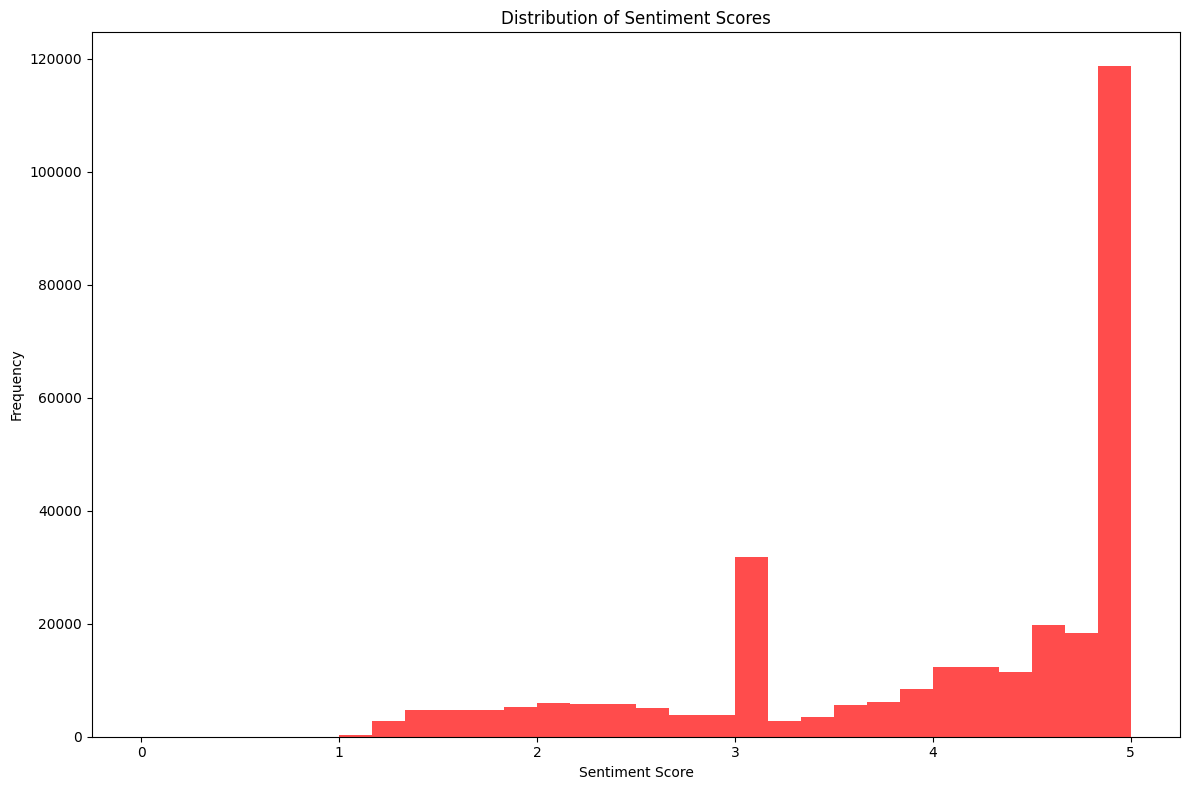

In [14]:
#visualise plot for sentiment_score
plt.figure(figsize=(12, 8))
plt.hist(sentiment_df['sentiment_score'], bins=30, color='red', alpha=0.7)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Binary Sentiment Distribution
(3.5 rating and above is positive, below is negative)

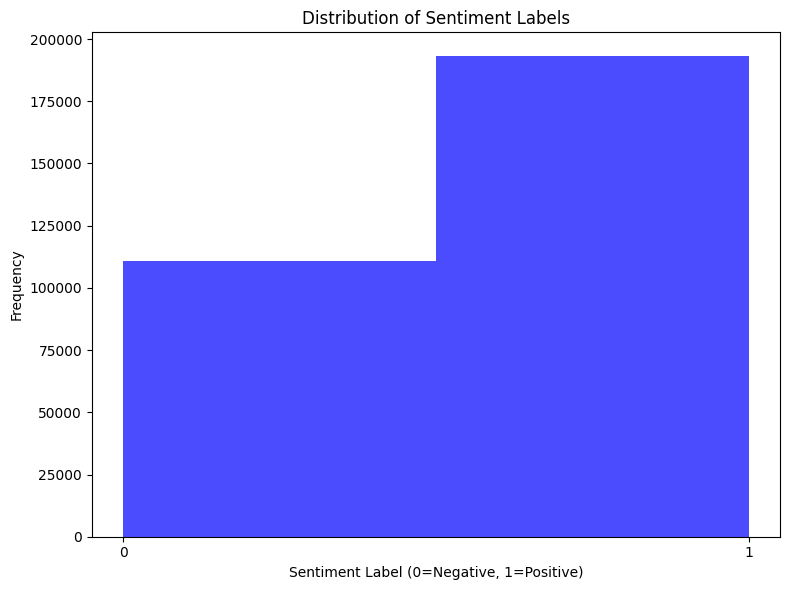

In [73]:
#binarise sentiment_score into positive and negative
sentiment_df['sentiment_label_binary'] = sentiment_df['sentiment_score'].apply(lambda x: 1 if x >= 4 else 0)
#visualise plot for sentiment_label
plt.figure(figsize=(8, 6))
plt.hist(sentiment_df['sentiment_label_binary'], bins=2, color='blue', alpha=0.7)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label (0=Negative, 1=Positive)')
plt.ylabel('Frequency')
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

# 3. Data Preprocessing

Using LabelEncoder to encode userId and gameId and Splitting Data into Train and Test Sets

In [74]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
sentiment_df['player'] = user_encoder.fit_transform(sentiment_df['playerid'])
sentiment_df['game'] = item_encoder.fit_transform(sentiment_df['gameid'])


## Dataset Sparsity () counts-only
U,I = sentiment_df['player'].nunique(), sentiment_df['game'].nunique()
N = len(sentiment_df)
sparsity = 1 - (N / (U * I))


def find_col(df, options):
    for col in df.columns:
        if col in options: return col
    raise ValueError("cannot find column")

#split dataset
train_df, test_df = train_test_split(sentiment_df, test_size=0.2, random_state=4222)


print(f"Players (U): {U}")
print(f"Games (I): {I}")
print(f"Interactions (N): {N}")
print(f"Data Sparsity: {sparsity*100:.2f}%")


Players (U): 65657
Games (I): 28234
Interactions (N): 303871
Data Sparsity: 99.98%


In [75]:
print("Training set length:", len(train_df))
print("Testing set length:", len(test_df))
num_players = sentiment_df['playerid'].nunique()
num_games = sentiment_df['gameid'].nunique()


Training set length: 243096
Testing set length: 60775


In [76]:
class NCFModel(nn.Module):
    def __init__(self, num_players, num_games, embedding_dim=32):
        super(NCFModel, self).__init__()
        self.player_embedding = nn.Embedding(num_players, embedding_dim)
        self.game_embedding = nn.Embedding(num_games, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, 256)  
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.output_layer = nn.Linear(64, 1)


    def forward(self, player, game):
        player_emb = self.player_embedding(player)
        game_emb = self.game_embedding(game)
        x = torch.cat([player_emb, game_emb], dim=-1)
        x = self.fc1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        logits = self.output_layer(x)
        return logits


In [77]:
class SteamDataset(Dataset):
    def __init__(self, dataframe):
        # Convert columns to tensors
        self.users = torch.tensor(dataframe["player"].values, dtype=torch.long)
        self.items = torch.tensor(dataframe["game"].values, dtype=torch.long)
        self.labels = torch.tensor(dataframe["sentiment_label_binary"].values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]


train_dataset = SteamDataset(train_df)
test_dataset = SteamDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)



Epoch 1 | Train Loss: 0.65322 | Val Loss: 0.64359 | RMSE: 0.47580 | NDCG@10: 0.67598 | Acc: 0.63674
Epoch 2 | Train Loss: 0.63114 | Val Loss: 0.63654 | RMSE: 0.47227 | NDCG@10: 0.67645 | Acc: 0.63979
Epoch 3 | Train Loss: 0.60270 | Val Loss: 0.63335 | RMSE: 0.47083 | NDCG@10: 0.67704 | Acc: 0.63832
Epoch 4 | Train Loss: 0.57143 | Val Loss: 0.65015 | RMSE: 0.47641 | NDCG@10: 0.67632 | Acc: 0.63179
Epoch 5 | Train Loss: 0.54004 | Val Loss: 0.65545 | RMSE: 0.47820 | NDCG@10: 0.67644 | Acc: 0.63235
Epoch 6 | Train Loss: 0.50819 | Val Loss: 0.68380 | RMSE: 0.48640 | NDCG@10: 0.67610 | Acc: 0.62695
Epoch 7 | Train Loss: 0.47510 | Val Loss: 0.71958 | RMSE: 0.49501 | NDCG@10: 0.67570 | Acc: 0.62466
Epoch 8 | Train Loss: 0.44286 | Val Loss: 0.75883 | RMSE: 0.50199 | NDCG@10: 0.67530 | Acc: 0.62198
Epoch 9 | Train Loss: 0.41014 | Val Loss: 0.79631 | RMSE: 0.50844 | NDCG@10: 0.67527 | Acc: 0.62221
Epoch 10 | Train Loss: 0.37866 | Val Loss: 0.85756 | RMSE: 0.51764 | NDCG@10: 0.67489 | Acc: 0.61604

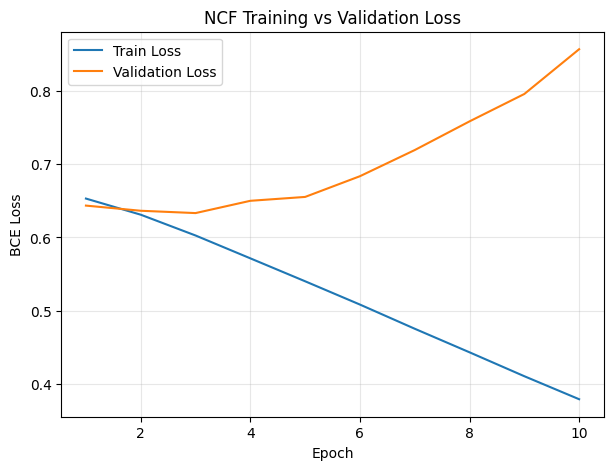

In [78]:

def ndcg_at_k(relevances, k):
    relevances = np.asarray(relevances)[:k]
    if relevances.size == 0:
        return 0.0
    dcg = np.sum((2.0 ** relevances - 1.0) / np.log2(np.arange(2, relevances.size + 2)))
    ideal_relevances = np.sort(relevances)[::-1]
    idcg = np.sum((2.0 ** ideal_relevances - 1.0) / np.log2(np.arange(2, ideal_relevances.size + 2)))
    return float(dcg / idcg) if idcg > 0 else 0.0

model_binary = NCFModel(num_players, num_games, embedding_dim=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_binary.to(device)

train_loader_binary = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader_binary  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

# Use logits-aware loss
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_binary.parameters(), lr=0.001)

num_epochs = 10

# --- Evaluation Function (NDCG@10 + Accuracy) ---
def evaluation_metrics(model, loader, device):
    model.eval()
    all_logits, all_labels, all_users = [], [], []
    total_val_loss, val_batches = 0.0, 0
    with torch.no_grad():
        for users, items, labels in loader:
            users  = users.to(device)
            items  = items.to(device)
            labels = labels.to(device).float()  

            logits = model(users, items).squeeze(1)       
            loss   = criterion(logits, labels)
            total_val_loss += loss.item()
            val_batches += 1

            all_logits.append(logits.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_users.append(users.cpu().numpy())

    logits = np.concatenate(all_logits)
    labels = np.concatenate(all_labels)
    users  = np.concatenate(all_users)

    # probabilities for metrics
    probs = 1.0 / (1.0 + np.exp(-logits))

    # RMSE (Brier-style)
    rmse = float(np.sqrt(np.mean((probs - labels) ** 2)))

    # NDCG@10 (per-user)
    ndcgs = []
    user_to_idx = {}
    for i, u in enumerate(users):
        uid = int(u)
        user_to_idx.setdefault(uid, []).append(i)

    for u, idxs in user_to_idx.items():
        scores_u = probs[idxs]
        labels_u = labels[idxs]
        order = np.argsort(-scores_u)          
        ranked_relevances = labels_u[order]    
        ndcgs.append(ndcg_at_k(ranked_relevances, 10))

    ndcg10 = float(np.mean(ndcgs)) if len(ndcgs) > 0 else 0.0

    # Accuracy (binary threshold at 0.5)
    preds_binary  = (probs >= 0.5).astype(int)
    labels_binary = (labels >= 0.5).astype(int)
    accuracy = float(np.mean(preds_binary == labels_binary))

    avg_val_loss = total_val_loss / val_batches if val_batches > 0 else 0.0
    return avg_val_loss, rmse, ndcg10, accuracy

train_losses, val_losses = [], []

for epoch in range(1, num_epochs + 1):
    model_binary.train()
    running_loss, num_batches = 0.0, 0

    for users, items, labels in train_loader_binary:
        users  = users.to(device)
        items  = items.to(device)
        labels = labels.to(device).float()  

        optimizer.zero_grad()
        logits = model_binary(users, items).squeeze(1)  
        loss = criterion(logits, labels)                 
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_batches += 1

    avg_train_loss = running_loss / max(num_batches, 1)
    train_losses.append(avg_train_loss)

    # eval
    avg_val_loss, rmse, ndcg10, acc = evaluation_metrics(model_binary, test_loader_binary, device)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.5f} | "
          f"Val Loss: {avg_val_loss:.5f} | RMSE: {rmse:.5f} | "
          f"NDCG@10: {ndcg10:.5f} | Acc: {acc:.5f}")

plt.figure(figsize=(7,5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses,  label="Validation Loss")
plt.title("NCF Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
#check precision and recall




In [ ]:
class SteamDatasetNonBinary(Dataset):
    def __init__(self, dataframe):
        # Convert columns to tensors
        self.users = torch.tensor(dataframe["player"].values, dtype=torch.long)
        self.items = torch.tensor(dataframe["game"].values, dtype=torch.long)
        self.labels = torch.tensor(dataframe["sentiment_label"].values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]


train_dataset = SteamDatasetNonBinary(train_df)
test_dataset = SteamDatasetNonBinary(test_df)
train_loader_nonbinary = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader_nonbinary = DataLoader(test_dataset, batch_size=512, shuffle=False)



Epoch 1 | Train Loss: 0.33156 | Val Loss: 0.23232 | RMSE: 0.48204 | NDCG@10: 0.67423 | Accuracy: 0.62824
Epoch 2 | Train Loss: 0.24109 | Val Loss: 0.22970 | RMSE: 0.47927 | NDCG@10: 0.67479 | Accuracy: 0.63501
Epoch 3 | Train Loss: 0.23402 | Val Loss: 0.22857 | RMSE: 0.47807 | NDCG@10: 0.67464 | Accuracy: 0.63656
Epoch 4 | Train Loss: 0.22981 | Val Loss: 0.22758 | RMSE: 0.47710 | NDCG@10: 0.67473 | Accuracy: 0.63707
Epoch 5 | Train Loss: 0.22607 | Val Loss: 0.22686 | RMSE: 0.47636 | NDCG@10: 0.67526 | Accuracy: 0.63839


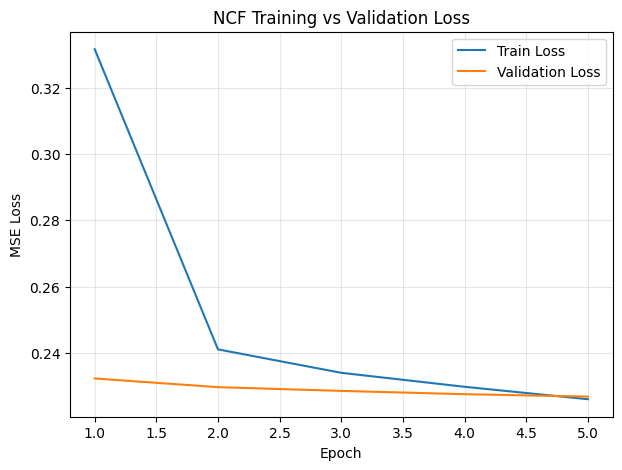

In [71]:
def ndcg_at_k(relevances, k):
    relevances = np.asarray(relevances)[:k]
    if relevances.size == 0:
        return 0.0
    dcg = np.sum((2 ** relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
    ideal_relevances = np.sort(relevances)[::-1]
    idcg = np.sum((2 ** ideal_relevances - 1) / np.log2(np.arange(2, ideal_relevances.size + 2)))
    return dcg / idcg if idcg > 0 else 0.0

model = NCFModel(num_players, num_games, embedding_dim=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimiser = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
EPOCHS = 5

def evaluation_metrics(model, loader, device):
    model.eval()
    all_preds, all_labels, all_users = [], [], []
    total_val_loss, val_batches = 0.0, 0
    with torch.no_grad():
        for users, items, labels in loader:
            users = users.to(device)
            items = items.to(device)
            labels = labels.to(device)

            preds = model(users, items).squeeze(1)
            loss = criterion(preds, labels)
            total_val_loss += loss.item()
            val_batches += 1

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_users.append(users.cpu().numpy())

    preds = np.concatenate(all_preds)
    labels = np.concatenate(all_labels)
    users = np.concatenate(all_users)

    rmse = np.sqrt(np.mean((preds - labels) ** 2))


    ndcgs = []
    user_to_idx = {}
    for i, u in enumerate(users):
        if int(u) not in user_to_idx:
            user_to_idx[int(u)] = []
        user_to_idx[int(u)].append(i)

    for u, idxs in user_to_idx.items():
        scores_u = preds[idxs]
        labels_u = labels[idxs]
        order = np.argsort(-scores_u)  
        ranked_relevances = labels_u[order]
        ndcgs.append(ndcg_at_k(ranked_relevances, 10))

    ndcg10 = float(np.mean(ndcgs)) if len(ndcgs) > 0 else 0.0

    #Accuracy
    preds_rounded = np.round(preds)
    accuracy = np.mean(preds_rounded == labels)

    avg_val_loss = total_val_loss / val_batches if val_batches > 0 else 0.0
    return avg_val_loss, rmse, ndcg10, accuracy


train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_train_loss, train_batches = 0.0, 0

    for users, items, labels in train_loader_nonbinary:
        users = users.to(device)
        items = items.to(device)
        labels = labels.to(device)

        optimiser.zero_grad()
        preds = model(users, items).squeeze(1)
        loss = criterion(preds, labels)
        loss.backward()
        optimiser.step()

        running_train_loss += loss.item()
        train_batches += 1

    avg_train_loss = running_train_loss / max(train_batches, 1)
    train_losses.append(avg_train_loss)

    #eval
    val_loss, rmse, ndcg10, acc = evaluation_metrics(model, test_loader_nonbinary, device)
    val_losses.append(val_loss)

    print(f"Epoch {epoch} | "
          f"Train Loss: {avg_train_loss:.5f} | "
          f"Val Loss: {val_loss:.5f} | "
          f"RMSE: {rmse:.5f} | "
          f"NDCG@10: {ndcg10:.5f} | "
          f"Accuracy: {acc:.5f}")


plt.figure(figsize=(7,5))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss")
plt.title("NCF Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

